First we import data.
The initial dataset contains wind power time series from 255 regions in Europe, which is 650MB.
We selected only time series from French regions and saved it to 'French_wind_data.csv' in the Git repository (50MB).
First, we import desired libraries and load data

In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('French_wind_data.csv')
print(len(df))
df.head()

262968


,FR30,FR71,FR25,FR42,FR82,FR41,FR83,FR10,FR61,FR62,...,FR22,FR23,FR53,FR21,FR63,FR81,FR72,FR43,FR26,FR51
0,0.26794,0.41513,0.32820,0.0,0.45992,0.00145,0.03030,0.06000,0.95,0.52765,...,0.13900,0.18590,0.16226,0.01750,0.11215,0.69298,0.23560,0.02576,0.00694,0.23464
1,0.22122,0.47283,0.29598,0.0,0.51182,0.00073,0.02525,0.06312,0.95,0.53303,...,0.12225,0.17896,0.18071,0.02285,0.13943,0.71172,0.27274,0.09015,0.01537,0.16941
2,0.18312,0.51863,0.23563,0.0,0.56804,0.00206,0.03106,0.06948,0.95,0.52972,...,0.10785,0.16866,0.15153,0.02809,0.15958,0.71879,0.29724,0.13212,0.02435,0.11864
3,0.16910,0.51003,0.16884,0.0,0.56824,0.00669,0.03864,0.07818,0.95,0.44746,...,0.11023,0.17440,0.11620,0.03564,0.14783,0.68143,0.27871,0.14091,0.02914,0.07421
4,0.15121,0.44058,0.15007,0.0,0.51733,0.00998,0.04899,0.08013,0.95,0.34736,...,0.11102,0.19267,0.10129,0.03822,0.13083,0.60158,0.21166,0.11682,0.02502,0.07181


The data has 262968 rows corresponding each to the output power of a windmill in a given region averaged over one hour. 263968 hours represent 30 years of data.
As can be seen, data is normalized to 1, where 1 means that there is enough wind in the region to have an average windmill produce 100% of its nominal output power.
Next, we plot the first 1000 hours of wind power for 4 regions, called FR30, FR71, FR25 and FR42.

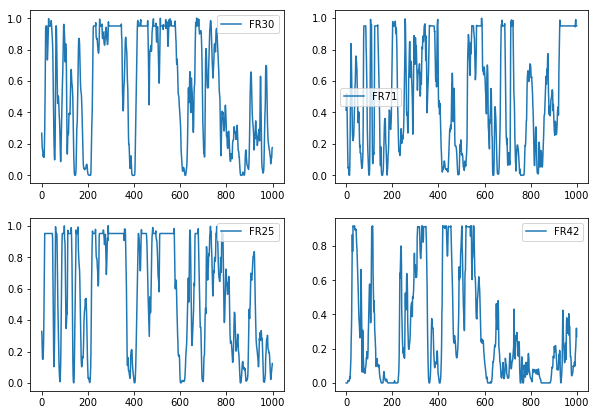

In [11]:
fig = plt.figure(figsize = (10, 7))
for i in range(4):
    P = fig.add_subplot(2, 2, i+1)
    P.plot(range(1000), df.iloc[0:1000, i], label = df.columns[i])
    P.legend()
plt.show()

Let's now compute the capacity factors (CF) of each region. That means how much average energy we can extract from a windmill in this region with nominal power of 1 over a long period of time (here 30 years!).
We save the results in a dictionary where keys are the names of the regions and values are the capacity factors.

In [15]:
CF = {}
for col in df.columns:
    CF[col] = np.mean(df[col])
    print(col + ': ' + str(CF[col]))

FR30: 0.3122650017491905
FR71: 0.3542998561039982
FR25: 0.3573299958168153
FR42: 0.12930007411548503
FR82: 0.2950181214825006
FR41: 0.16272984971555257
FR83: 0.1127869997110043
FR10: 0.19432017983176228
FR61: 0.5854473917358353
FR62: 0.24141895953119427
FR52: 0.29200040514435827
FR24: 0.18879264366767232
FR22: 0.23503440897752087
FR23: 0.3160449186592449
FR53: 0.26133604195186777
FR21: 0.163779056234977
FR63: 0.2236238365884608
FR81: 0.27688264180432826
FR72: 0.25242025832039716
FR43: 0.1252879319156515
FR26: 0.10463357267803858
FR51: 0.31653705842530616


As can be seen, there are 15 regions with CF < 0.29, so we'll discard them.
There are 6 regions with 0.29 < CF < 0.36, we will select these regions.
Finally there is 1 region with a very high CF=0.585, which corresponds to offshore wind.
Given that offshore wind is still a nascent industry with much higher costs than onshore, we will consider it apart.

In [37]:
cols = []
for col in list(CF):
    if ((CF[col] < 0.4) and (CF[col] > 0.29)):
        cols.append(col)
df2 = df[cols] # Onshore regions
df3 = df['FR61'] # Offshore region

In order to have a better idea of what the capacity factor means, let's plot the percentage of time each region has an output power higher than a given value for values between 0 and 1.

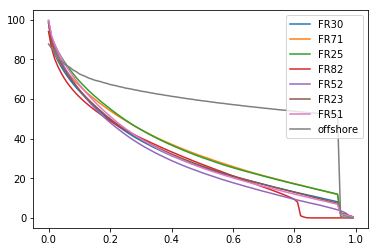

In [38]:
for col in df2.columns:
    M = []
    for i in range(100):
        M.append(100 * len(df2.loc[df2[col] > i/100, col]) / len(df2))
    plt.plot(np.arange(0,1,0.01), M, label=col)
    plt.legend()
M = []
for i in range(100):
    M.append(100 * len(df3[df3 > i/100]) / len(df3))
plt.plot(np.arange(0,1,0.01), M, label='offshore')
plt.legend()
plt.show()

The offshore platform performs clearly better with 95% efficiency >50% of the time (95% instead of 100% due to modelling assumptions in the dataset).
On the other hand, no onshore platform can even work at 80% efficiency 20% of the time. This means that the wind patterns have high variability, and this is why we are interested in combining multiple regions to decrease the variability of the power production.

Now, let's model how much useful energy we can get out of wind power in each region. We will assume that we have a constant consumption of 1 over 30 years (obviously a very inaccurate approximation, but good enough for a start). Every time the power plant produces more than 1, some power must be "curtailed" and some energy is lost. 
Let's represent the efficiency of each region as a function of the power installed:
left = Total useful energy (in % of total consumption) vs size of the plant
right = Efficiency (in %) of a power plant as a function of the total useful energy

FR30
FR71
FR25
FR82
FR52
FR23
FR51


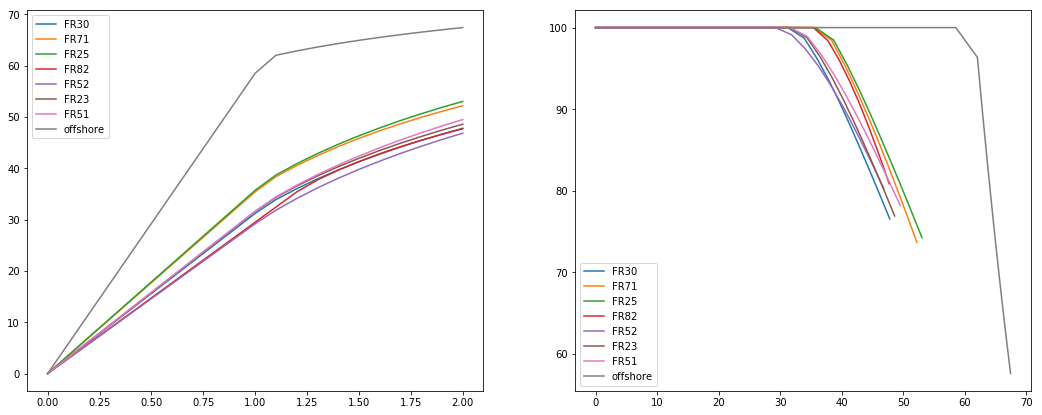

In [76]:
fig = plt.figure(figsize = (18, 7))
Energy1 = {}
Efficiency1 = {}
for col in df2.columns:
    print(col)
    M = []
    for i in range(21):
        M.append(100 * np.mean(np.minimum(1, df2[col]*i/10)))
    N = [100]
    for i in range(1, 21):
        N.append(100 * M[i]/M[10] * 10/i)
    Energy1[col] = M
    Efficiency1[col] = N
    P = fig.add_subplot(1, 2, 1)
    plt.plot(np.arange(0,2.1,0.1), M, label=col)
    plt.legend()
    P = fig.add_subplot(1, 2, 2)
    plt.plot(M, N, label=col)
    plt.legend()
M = []
for i in range(21):
    M.append(100 * np.mean(np.minimum(1, df3*i/10)))
N = [100]
for i in range(1, 21):
    N.append(100 * M[i]/M[10] * 10/i)
P = fig.add_subplot(1, 2, 1)
plt.plot(np.arange(0,2.1,0.1), M, label='offshore')
plt.legend()
P = fig.add_subplot(1, 2, 2)
plt.plot(M, N, label='offshore')
plt.legend()
plt.show()

The graph on the left gives a clear idea of how the total useful energy of a plant increases with the size of the plant.
The graph on the right is probably the best way to evaluate the performance of each region in terms of tradeoffs between total useful energy and efficiency. The higher the total energy, the larger the plant needs to be, and the more power is curtailed, which explains why the efficiency drops.

An optimum of 36% of the total energy consumption can be provided by onshore wind with 100% efficiency (FR25 = Normandie, in the north-west of France), but in order to achieve 50% of the total consumption, one has to build a much larger plant, which will have only 80% efficiency, corresponding to 20% energy lost.
Up to 60% of the total energy consumption can be provided by offshore wind with 100% efficiency, which is very attractive if the costs can decrease at similar levels as onshore.

In the meantime, let's see if we can improve onshore wind by combining production from several regions, which will hopefully "smoothen" the overall production.
For that, let's select the best region (FR25), combine it with every other region one by one (with variable ratio, but keeping a total nominal power of 1) and see how the capacity factor changes.

In [78]:
CF2 = {}
for col in df2.columns:
    Energy = []
    Efficiency = []
    for i in range(11):
        P1 = 0.1*i*df2[col] + (1-0.1*i)*df2['FR25']
        P = []
        E = [1]
        for j in range(21):
            P.append(100 * np.mean(np.minimum(1, P1*j/10)))
        Energy.append(P)
        for j in range(1,21):
            E.append(P[j]/P[10] * 10/j)
        Efficiency.append(E)
    CF2[col] = (Energy, Efficiency)

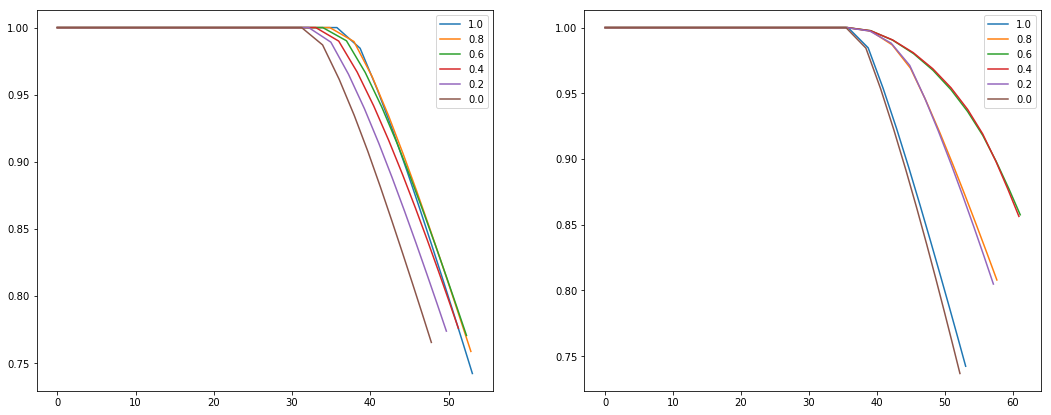

In [93]:
fig = plt.figure(figsize = (18, 7))
col1 = 'FR30'
P = fig.add_subplot(1, 2, 1)
for i in range(0, 11, 2):
    plt.plot(CF2[col1][0][i], CF2[col1][1][i], label=(10-i)/10)
    plt.legend()
col2 = 'FR71'
P = fig.add_subplot(1, 2, 2)
for i in range(0, 11, 2):
    plt.plot(CF2[col2][0][i], CF2[col2][1][i], label=(10-i)/10)
    plt.legend()
plt.show()

We tested all the regions but selected two of them. For both graphs, we represent the plant efficiency as a function of the total useful energy. 1.0 represents when 100% of the power comes from FR25, and 0.0 represents when 100% of the power comes from FR30/FR71.

FR30 (left graph) is an example of a region that, combined with FR25, doesn't improve the efficiency, which means that winds in both regions are highly correlated, so the power produced by each region cannot balance the power from the other region. It makes sense as these two regions are neighbors without any mountains in between.
FR71 (right graph) shows a totally different situation. Combining FR25 and FR71 50/50 allows to achieve 50% useful energy with 96% efficiency (as opposed to 80% for FR25 only), and even 60% useful energy with 89% efficiency (11% curtailment).

We also tested with 3 regions, but no significant improvement was noticed.

In [111]:
CF2off = {}
for col in df2.columns:
    Energy = []
    Efficiency = []
    for i in range(11):
        P1 = 0.1*i*df2[col] + (1-0.1*i)*df3
        P = []
        E = [1]
        for j in range(31):
            P.append(100 * np.mean(np.minimum(1, P1*j/10)))
        Energy.append(P)
        for j in range(1,31):
            E.append(P[j]/P[10] * 10/j)
        Efficiency.append(E)
    CF2off[col] = (Energy, Efficiency)

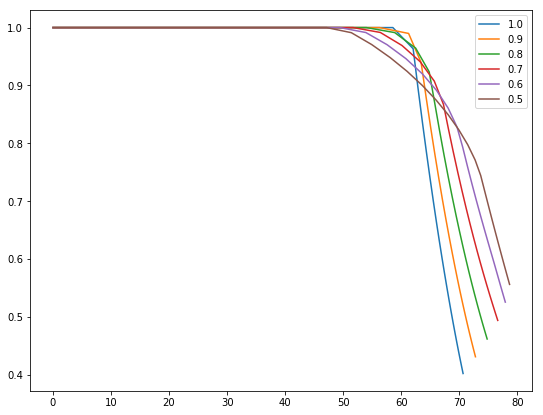

In [119]:
fig = plt.figure(figsize = (9, 7))
col1 = 'FR25'
for i in range(0, 6, 1):
    plt.plot(CF2off[col1][0][i], CF2off[col1][1][i], label=(10-i)/10)
    plt.legend()
plt.show()

Doing a similar procedure as previously, but this time with the offshore region + one region onshore (FR25 = Normandie), the useful wind energy can reach up to 72% of the total energy consumption with a 78% efficiency (22% curtailment), with 50% nominal power from offshore and 50% nominal power from FR25.

Next, let's plot a sample of power generation time series of 1000hours (40 days) for each interesting configuration.<br />
TS1: There is one power plant in FR25 providing 36% of total energy and running at 100% efficiency.<br />
TS2: The FR25 power plant is scaled up by a factor of 2, providing 50% of total energy at 80% efficiency.<br />
TS3: FR25 and FR71 are combined to provide 50% of total energy with 96% efficiency.<br />
TS4: FR25+FR71 are scaled up by 40%, providing 60% total energy with 89% efficiency.<br />
TS5: Offshore wind can provide up to 60% energy with 100% efficiency.<br />
TS6: Combining offshore wind and FR25 50/50, wind power can generate 72% of total energy with 78% efficiency.

In [155]:
TS1 = df['FR25']/0.94
TS2 = df['FR25']*2
TS3 = (df['FR25'] + df['FR71'])*0.8
TS4 = (df['FR25'] + df['FR71'])*1.1
TS5 = df['FR61']/0.94
TS6 = (df['FR61'] + df['FR25'])/0.94
TS = [TS1, TS2, TS3, TS4, TS5, TS6]
TS_name = ['FR25', 'FR25+', 'FR25-FR71', 'FR25-FR71+', 'offshore', 'offshore-FR25']

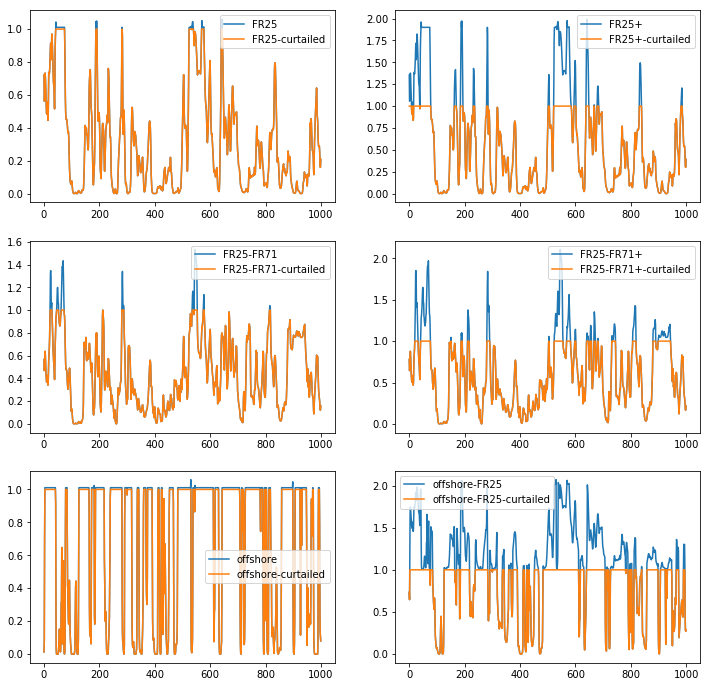

In [156]:
Legends = []

fig = plt.figure(figsize = (12, 12))
for i in range(6):
    P = fig.add_subplot(3, 2, i+1)
    P.plot(range(1000), TS[i][100000:101000], label=TS_name[i])
    P.plot(range(1000), np.minimum(1, TS[i][100000:101000]), label=TS_name[i]+'-curtailed')
    P.legend()
plt.show()

Finally, the next graph shows the percentage of hours when wind power provides more than a certain amount (x-axis) of total power. For example, we see that the configuration 'offshore+FR71' provides more than 50% of the power consumption 70% of the time, and more than 100% of the power consumption 60% of the time.

In [157]:
Hours_statistics = {}
for i in range(6):
    col = TS[i]
    Hours = []
    for j in range(11):
        Hours.append(100 * sum(col > j/10) / len(col))
    Hours_statistics[TS_name[i]] = Hours
        

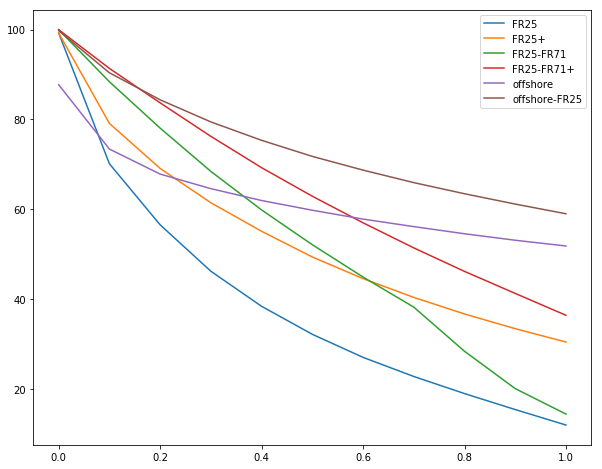

In [159]:
fig = plt.figure(figsize = (10, 8))
for i in range(6):
    plt.plot(np.arange(0,1.1, 0.1), Hours_statistics[TS_name[i]], label = TS_name[i])
plt.legend()
plt.show()